In [1]:
import os
import sys
import inspect


from tcsim.system import*
from tcsim.visualization import*
from tcsim.gates import*
from scipy import optimize

X = (a.dag()+a)/2
P = (1j*(a.dag()-a))/2

def varianceP(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    print(qt.expect(P**2,psi1))
    return qt.expect(P**2,psi1)


In [2]:
#fitting

#sys.path.insert(0,r'C:\\Users\\canda\\phd_2022\\Xiaozhou') 

from qutip import*
from qutip.qip.operations import rx, ry
import numpy as np
# from visualization import plot_wigner, plot_char
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import scipy as sc
from scipy.optimize import curve_fit
import math
import h5py
import tcsim.analyze.fit as fit

def char_func(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))
    N = state.dims[0][1]

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = qt.expect(qt.displace(N, alpha_x +1j*alpha_p),qt.ptrace(state,1))
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag   

def normalize(data, min, max):
    range = data.max() - data.min()
    a = (data - data.min()) / range
    return a

### vac 

M1 The resulting state is squeezed by -0.0 dB


C:\Users\jonat\AppData\Local\Temp\ipykernel_18476\3226691699.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(p)


y_anti_squeezing: 1.0
x_squeezing: 1.0
M2: squeezing = 20 *log10 (x/1) = 0.0 dB


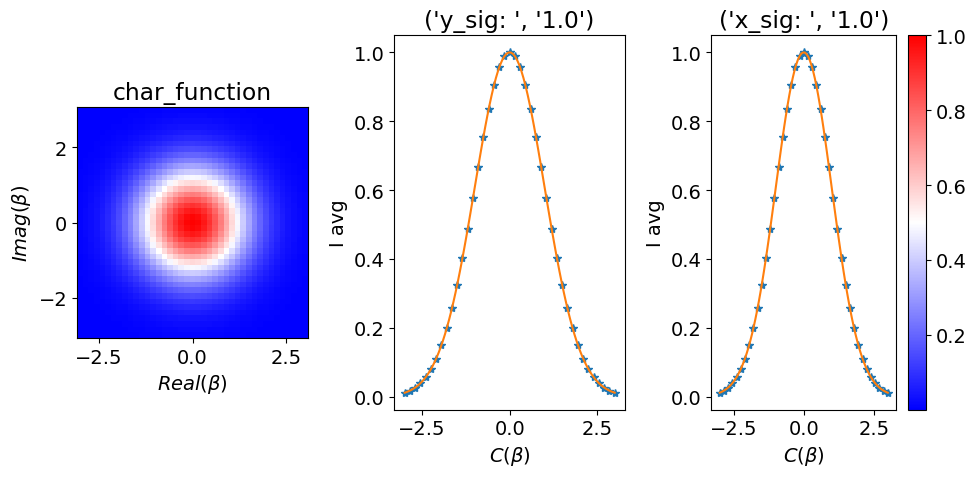

In [4]:
# Method 1
state =vac

db = -10*np.log10(qt.expect(P**2,state)*4)
print(f"M1 The resulting state is squeezed by {db} dB")

#########################################################################################################################
# Method 2

xvec = np.linspace(-3,3,41)
CF_real, CF_imag = char_func(state, xvec)

#two axis cut
fig, ax = plt.subplots(1,3, figsize=(10,5))
px_cut = CF_real[:,20]
py_cut = CF_real[20]


data_original = CF_real

p = ax[0].pcolormesh(xvec,xvec,  data_original, cmap = 'bwr', vmin = data_original.min(), vmax= data_original.max(), shading = 'auto')
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$Real(\beta)$')
ax[0].set_ylabel(r'$Imag(\beta)$')
ax[0].set_title('char_function')
fig.colorbar(p)


## py cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_y = fit.do_fit(fit_func, xvec, py_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
py_cut_fitting = fit.eval_fit(fit_func, params_y, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
y_anti_squeezing = round(params_y['sig'].value,3) #sigma lower
ax[1].plot(xvec, py_cut, "*")
ax[1].plot(xvec_fit, py_cut_fitting, '-')
ax[1].set_xlabel(r'$C(\beta)$')
ax[1].set_ylabel('I avg')
ax[1].set_title(("y_sig: ",f"{y_anti_squeezing}"))

print("y_anti_squeezing:", y_anti_squeezing)

## px cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_x = fit.do_fit(fit_func, xvec, px_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
px_cut_fitting = fit.eval_fit(fit_func, params_x, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
x_squeezing = round(params_x['sig'].value,3)
ax[2].plot(xvec, px_cut, "*")
ax[2].plot(xvec_fit, px_cut_fitting, '-')
ax[2].set_xlabel(r'$C(\beta)$')
ax[2].set_ylabel('I avg')
ax[2].set_title(("x_sig: ",f"{x_squeezing}"))
print("x_squeezing:", x_squeezing)
fig.tight_layout()


print("M2: squeezing = 20 *log10 (x/1) =", 20*np.log10(x_squeezing/1), "dB" )

### Parameters for one step

In [3]:
initial_guess = [1, 0]
result = optimize.minimize(varianceP, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

0.25
0.2499999999999999
0.25000000451900567
0.1810226037121579
0.18102260371215817
0.1810226059716607
0.15803013970713983
0.15803013970713967
0.15803013970713972
[ 0.99999997 -0.60653067]


record of good values:
[ 1.00000001 -0.60653066]-> 0.158

In [6]:
def squeezingStateOneStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
 
    return psi1



In [25]:
# Method 1
state = squeezingStateOneStep(fitted_params)
print("fitted_params:", fitted_params)
plot_char(state)
db = -10*np.log10(qt.expect(P**2,state)*4)
print(f"M1: The resulting state is squeezed by {db} dB")

#########################################################################################################################
# Method 2

xvec = np.linspace(-5,5,61)
CF_real, CF_imag = char_func(state, xvec)

#two axis cut
fig, ax = plt.subplots(1,3, figsize=(10,5))
px_cut = CF_real[:,30]
py_cut = CF_real[30]

data_original = CF_real

p = ax[0].pcolormesh(xvec,xvec,  data_original, cmap = 'bwr', vmin = data_original.min(), vmax= data_original.max(), shading = 'auto')
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$Real(\beta)$')
ax[0].set_ylabel(r'$Imag(\beta)$')
ax[0].set_title('char_function')
fig.colorbar(p)


## py cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_y = fit.do_fit(fit_func, xvec, py_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
py_cut_fitting = fit.eval_fit(fit_func, params_y, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
y_anti_squeezing = round(params_y['sig'].value,3) #sigma lower
ax[1].plot(xvec, py_cut, "*")
ax[1].plot(xvec_fit, py_cut_fitting, '-')
ax[1].set_xlabel(r'$C(\beta)$')
ax[1].set_ylabel('I avg')
ax[1].set_title(("y_sig: ",f"{y_anti_squeezing}"))

print("y_anti_squeezing:", y_anti_squeezing)

## px cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_x = fit.do_fit(fit_func, xvec, px_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
px_cut_fitting = fit.eval_fit(fit_func, params_x, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
x_squeezing = round(params_x['sig'].value,3)
ax[2].plot(xvec, px_cut, "*")
ax[2].plot(xvec_fit, px_cut_fitting, '-')
ax[2].set_xlabel(r'$C(\beta)$')
ax[2].set_ylabel('I avg')
ax[2].set_title(("x_sig: ",f"{x_squeezing}"))
print("x_squeezing:", x_squeezing)
fig.tight_layout()


print("M2: squeezing = 20 *log10 (x/1) =", 20*np.log10(x_squeezing/1), "dB" )

fitted_params: [ 1.93872874  0.44093118 -0.57282005 -1.06157507]
M1: The resulting state is squeezed by -1.6300505805038068 dB


In [22]:
calc_squeez_parameter(3)

0.3453877639491068

C:\Users\jonat\AppData\Local\Temp\ipykernel_18476\3302274682.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(p)


y_anti_squeezing: 0.562
x_squeezing: 1.758
M1: The resulting state is squeezed by 5.000000000000008 dB
M2: squeezing = 20 *log10 (x/1) = 4.900377414755061 dB


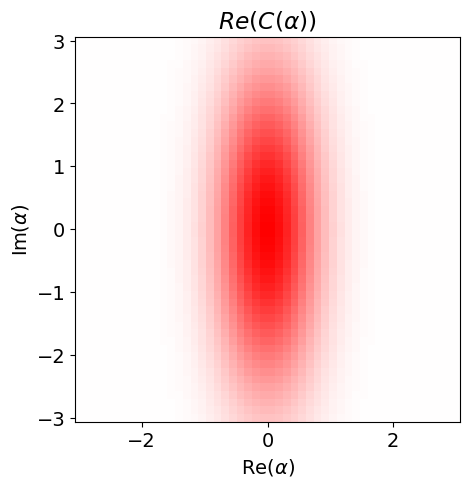

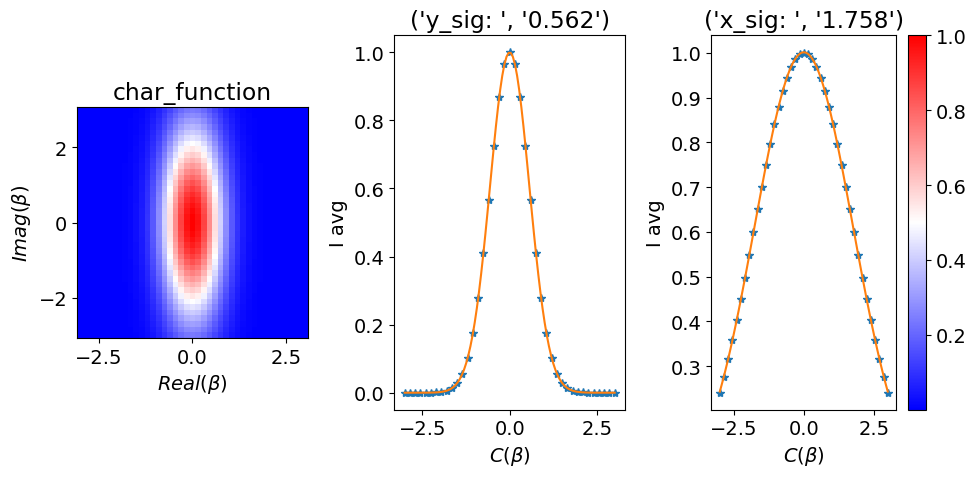

In [24]:
from qutip import*
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

state2 = tensor(Iq,squeeze(N,calc_squeez_parameter(-5)))*vac
plot_char(state2)

xvec = np.linspace(-3,3,41)
CF_real, CF_imag = char_func(state2, xvec)

#two axis cut
fig, ax = plt.subplots(1,3, figsize=(10,5))
px_cut = CF_real[:,20]
py_cut = CF_real[20]

data_original = CF_real

p = ax[0].pcolormesh(xvec,xvec,  data_original, cmap = 'bwr', vmin = data_original.min(), vmax= data_original.max(), shading = 'auto')
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$Real(\beta)$')
ax[0].set_ylabel(r'$Imag(\beta)$')
ax[0].set_title('char_function')
fig.colorbar(p)


## py cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_y = fit.do_fit(fit_func, xvec, py_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
py_cut_fitting = fit.eval_fit(fit_func, params_y, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
y_anti_squeezing = round(params_y['sig'].value,3) #sigma lower
ax[1].plot(xvec, py_cut, "*")
ax[1].plot(xvec_fit, py_cut_fitting, '-')
ax[1].set_xlabel(r'$C(\beta)$')
ax[1].set_ylabel('I avg')
ax[1].set_title(("y_sig: ",f"{y_anti_squeezing}"))

print("y_anti_squeezing:", y_anti_squeezing)

## px cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_x = fit.do_fit(fit_func, xvec, px_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
px_cut_fitting = fit.eval_fit(fit_func, params_x, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
x_squeezing = round(params_x['sig'].value,3)
ax[2].plot(xvec, px_cut, "*")
ax[2].plot(xvec_fit, px_cut_fitting, '-')
ax[2].set_xlabel(r'$C(\beta)$')
ax[2].set_ylabel('I avg')
ax[2].set_title(("x_sig: ",f"{x_squeezing}"))
print("x_squeezing:", x_squeezing)
fig.tight_layout()

db = -10*np.log10(qt.expect(P**2,state2)*4)
print(f"M1: The resulting state is squeezed by {db} dB")

print("M2: squeezing = 20 *log10 (x/1) =", 20*np.log10(x_squeezing/1), "dB" )


### Parameters for two steps

In [8]:
def varianceP(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    print(qt.expect(P**2,psi2))
    return qt.expect(P**2,psi2)

initial_guess = [1,1, -.5,-1 ]
result = optimize.minimize(varianceP, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

0.5293509576553854
0.529350953410135
0.529350970107743
0.529350939677079
0.5293509580117376
0.3236044055441104
0.3236044085165477
0.32360440892709896
0.32360441523522226
0.32360440324500106
0.16853184576444563
0.16853184643933303
0.16853184453133258
0.1685318474207988
0.16853184442051877
0.15438502515558575
0.1543850250411062
0.15438502479724786
0.1543850261515234
0.15438502513110913
0.15036492079488417
0.15036492021490325
0.15036492063405044
0.15036492131775037
0.15036492126508486
0.14387820152328143
0.14387820019993336
0.14387820174475766
0.1438782012029686
0.14387820261011752
0.1381977688074703
0.13819776636340295
0.13819777045528775
0.13819776657920566
0.13819777036475286
0.1272539146138476
0.1272539123906245
0.1272539158756598
0.12725391276703663
0.12725391599184796
0.09692768750257029
0.0969276864516096
0.09692768688933606
0.09692768725325354
0.09692768798607199
0.16655602392243232
0.16655602530429514
0.16655603113810033
0.1665560205081712
0.16655602146550336
0.08387544281384113


record of good values:
[ 1.93872301  0.4409296  -0.57281612 -1.06157337] -> 0.08

In [9]:
def squeezingStateTwoStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    
    
    psi1 = U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_1)*psi1
    psi3 = U_ideal_operator(u_2)*psi2
    psi4 = V_ideal_operator(v_2)*psi3
 
    return [psi1, psi2, psi3, psi4]




fitted_params: [ 1.93872874  0.44093118 -0.57282005 -1.06157507]
M1: The resulting state is squeezed by 4.834173143871255 dB


C:\Users\jonat\AppData\Local\Temp\ipykernel_18476\2025033472.py:30: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(p)


y_anti_squeezing: 0.483
x_squeezing: 1.792
M2: squeezing = 20 *log10 (x/1) = 5.066760106522128 dB


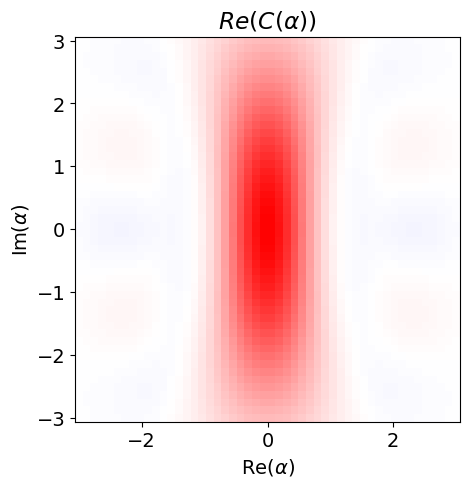

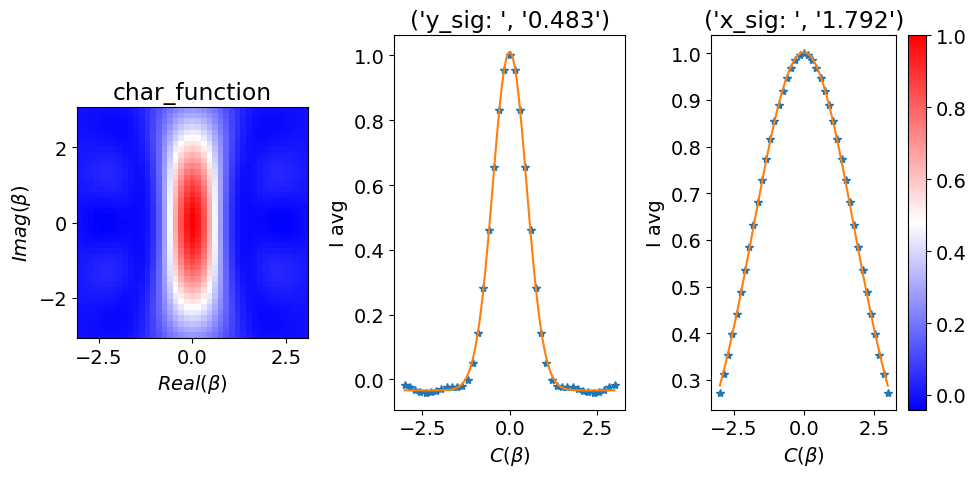

In [10]:
# Method 1
state = squeezingStateTwoStep(fitted_params)
print("fitted_params:", fitted_params)
db = -10*np.log10(qt.expect(P**2,state[3])*4)
print(f"M1: The resulting state is squeezed by {db} dB")
plot_char(state[3])

#########################################################################################################################
# Method 2

state = state[3]

#char func
xvec = np.linspace(-3,3,41)
CF_real, CF_imag = char_func(state, xvec)

#two axis cut
fig, ax = plt.subplots(1,3, figsize=(10,5))
px_cut = CF_real[:,20]
py_cut = CF_real[20]


data_original = CF_real

p = ax[0].pcolormesh(xvec,xvec,  data_original, cmap = 'bwr', vmin = data_original.min(), vmax= data_original.max(), shading = 'auto')
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$Real(\beta)$')
ax[0].set_ylabel(r'$Imag(\beta)$')
ax[0].set_title('char_function')
fig.colorbar(p)


## py cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_y = fit.do_fit(fit_func, xvec, py_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
py_cut_fitting = fit.eval_fit(fit_func, params_y, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
y_anti_squeezing = round(params_y['sig'].value,3) #sigma lower
ax[1].plot(xvec, py_cut, "*")
ax[1].plot(xvec_fit, py_cut_fitting, '-')
ax[1].set_xlabel(r'$C(\beta)$')
ax[1].set_ylabel('I avg')
ax[1].set_title(("y_sig: ",f"{y_anti_squeezing}"))

print("y_anti_squeezing:", y_anti_squeezing)

## px cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_x = fit.do_fit(fit_func, xvec, px_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
px_cut_fitting = fit.eval_fit(fit_func, params_x, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
x_squeezing = round(params_x['sig'].value,3)
ax[2].plot(xvec, px_cut, "*")
ax[2].plot(xvec_fit, px_cut_fitting, '-')
ax[2].set_xlabel(r'$C(\beta)$')
ax[2].set_ylabel('I avg')
ax[2].set_title(("x_sig: ",f"{x_squeezing}"))
print("x_squeezing:", x_squeezing)
fig.tight_layout()


print("M2: squeezing = 20 *log10 (x/1) =", 20*np.log10(x_squeezing/1), "dB" )

## Parameters for three steps

In [1]:
def varianceP(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
    print(qt.expect(P**2,psi3))
    return qt.expect(P**2,psi3)


import random#
#initial_guess = [ 1,1,1,-1,-1,-1]
initial_guess = [random.randrange(-10, 10, 1)/10 for i in range(6)]

result = optimize.minimize(varianceP, initial_guess, method= 'SLSQP' )
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

NameError: name 'optimize' is not defined

record of good values: 
\
[ 1.84531183,  0.42317944, -0.54502311, -1.10388431,  1.98896233, -0.33341153] -> 0.05594382101928646 \
[ 0.7638112  -0.61285946  2.52561177  0.33656678 -0.71748393 -0.84671525] -> 0.057597773122561396 \
[-0.84571552  0.61335235  2.63648988  0.30560449 -0.91694799 -0.80353261] - > 0.04867267133276083

The resulting state is squeezed by 5.499401112920308 dB


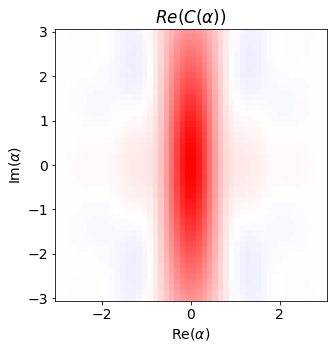

In [11]:
def squeezingStateThreeStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
 
    return psi3

state = squeezingStateThreeStep(fitted_params)
plot_char(state)
db = -10*np.log10(qt.expect(P**2,state)*4)
print(f"The resulting state is squeezed by {db} dB")

In [5]:


# expt value 


u_1 = -0.84571552
v_1 =  0.61335235 
u_2 = 2.63648988 
v_2 = 0.30560449 
u_3 = -0.91694799 
v_3 = -0.80353261

psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2




M1: The resulting state is squeezed by 7.106548261049889 dB
fitted_params: [-0.84571552, 0.61335235, 2.63648988, 0.30560449, -0.91694799, -0.80353261]
y_anti_squeezing: 0.381
x_squeezing: 2.554
M2: squeezing = 20 *log10 (x/1) = 8.144417858547929 dB
end


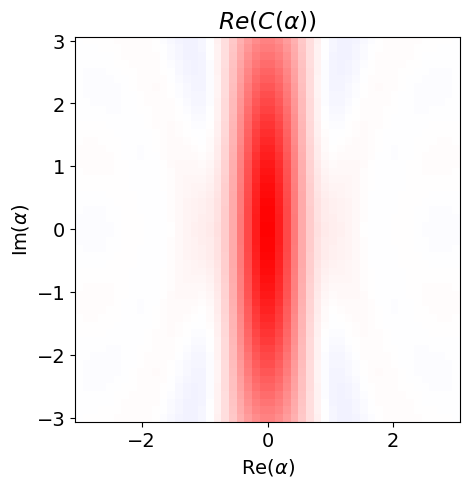

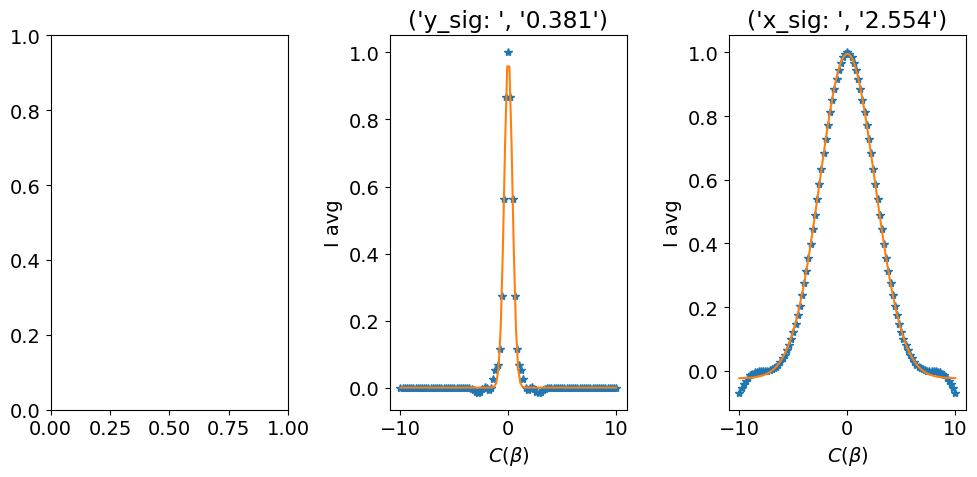

In [10]:
# Method 1
state = psi3
plot_char(state)
db = -10*np.log10(qt.expect(P**2,state)*4)
print(f"M1: The resulting state is squeezed by {db} dB")
fitted_params = [u_1, v_1, u_2, v_2, u_3, v_3]
print("fitted_params:", fitted_params)

#########################################################################################################################
# Method 2


#char func
xvec = np.linspace(-10,10,101)
CF_real, CF_imag = char_func(state, xvec)

#two axis cut
fig, ax = plt.subplots(1,3, figsize=(10,5))
px_cut = CF_real[:,50]
py_cut = CF_real[50]


data_original = CF_real

# p = ax[0].pcolormesh(xvec,xvec,  data_original, cmap = 'bwr', vmin = data_original.min(), vmax= data_original.max(), shading = 'auto')
# ax[0].set_aspect('equal')
# ax[0].set_xlabel(r'$Real(\beta)$')
# ax[0].set_ylabel(r'$Imag(\beta)$')
# ax[0].set_title('char_function')
# fig.colorbar(p)


## py cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_y = fit.do_fit(fit_func, xvec, py_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
py_cut_fitting = fit.eval_fit(fit_func, params_y, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
y_anti_squeezing = round(params_y['sig'].value,3) #sigma lower
ax[1].plot(xvec, py_cut, "*")
ax[1].plot(xvec_fit, py_cut_fitting, '-')
ax[1].set_xlabel(r'$C(\beta)$')
ax[1].set_ylabel('I avg')
ax[1].set_title(("y_sig: ",f"{y_anti_squeezing}"))

print("y_anti_squeezing:", y_anti_squeezing)

## px cut
#fit_func = 'gaussian_fixofs'
fit_func = 'gaussian'
params_x = fit.do_fit(fit_func, xvec, px_cut)
xvec_fit = np.linspace(min(xvec), max(xvec), 100)
px_cut_fitting = fit.eval_fit(fit_func, params_x, xvec_fit)
# print('f0=',params['f0'].value)
# f0 = params['f0'].value
x_squeezing = round(params_x['sig'].value,3)
ax[2].plot(xvec, px_cut, "*")
ax[2].plot(xvec_fit, px_cut_fitting, '-')
ax[2].set_xlabel(r'$C(\beta)$')
ax[2].set_ylabel('I avg')
ax[2].set_title(("x_sig: ",f"{x_squeezing}"))
print("x_squeezing:", x_squeezing)
fig.tight_layout()


print("M2: squeezing = 20 *log10 (x/1) =", 20*np.log10(x_squeezing/1), "dB" )
print("end")